In [17]:
import os
import argparse
import torch
import numpy as np
from pandas import read_csv, concat
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    TrainingArguments, Trainer
from datasets import load_metric, load_dataset, Features, Value, ClassLabel, Dataset, Split, concatenate_datasets
from sklearn.model_selection import train_test_split

modelname = 'roberta-base'
classes = ['acc-phys', 'cmp-lg', 'cs.CE', 'cs.GT', 'cs.PL', 'funct-an', 'math.DS', 'math.OC', 'nucl-ex',
           'physics.gen-ph', 'q-bio.MN', 'q-fin.ST', 'adap-org', 'comp-gas', 'cs.CG', 'cs.HC', 'cs.RO', 'gr-qc',
           'math.FA', 'math-ph', 'nucl-th', 'physics.geo-ph', 'q-bio.NC', 'q-fin.TR', 'alg-geom', 'cond-mat.dis-nn',
           'cs.CL', 'cs.IR', 'cs.SC', 'hep-ex', 'math.GM', 'math.PR', 'patt-sol', 'physics.hist-ph', 'q-bio.OT',
           'quant-ph', 'ao-sci', 'cond-mat.mes-hall', 'cs.CR', 'cs.IT', 'cs.SD', 'hep-lat', 'math.GN', 'math.QA',
           'physics.acc-ph', 'physics.ins-det', 'q-bio.PE', 'solv-int', 'astro-ph.CO', 'cond-mat.mtrl-sci', 'cs.CV',
           'cs.LG', 'cs.SE', 'hep-ph', 'math.GR', 'math.RA', 'physics.ao-ph', 'physics.med-ph', 'q-bio.QM', 'stat.AP',
           'astro-ph.EP', 'cond-mat.other', 'cs.CY', 'cs.LO', 'cs.SI', 'hep-th', 'math.GT', 'math.RT', 'physics.app-ph',
           'physics.optics', 'q-bio.SC', 'stat.CO', 'astro-ph.GA', 'cond-mat.quant-gas', 'cs.DB', 'cs.MA', 'cs.SY',
           'math.AC', 'math.HO', 'math.SG', 'physics.atm-clus', 'physics.plasm-ph', 'q-bio.TO', 'stat.ME',
           'astro-ph.HE', 'cond-mat.soft', 'cs.DC', 'cs.MM', 'dg-ga', 'math.AG', 'math.IT', 'math.SP',
           'physics.atom-ph', 'physics.pop-ph', 'q-bio', 'stat.ML', 'astro-ph.IM', 'cond-mat.stat-mech', 'cs.DL',
           'cs.MS', 'econ.EM', 'math.AP', 'math.KT', 'math.ST', 'physics.bio-ph', 'physics.soc-ph', 'q-fin.CP',
           'stat.OT', 'astro-ph.SR', 'cond-mat.str-el', 'cs.DM', 'cs.NA', 'econ.GN', 'math.AT', 'math.LO', 'mtrl-th',
           'physics.chem-ph', 'physics.space-ph', 'q-fin.EC', 'stat.TH', 'astro-ph', 'cond-mat.supr-con', 'cs.DS',
           'cs.NE', 'econ.TH', 'math.CA', 'math.MG', 'nlin.AO', 'physics.class-ph', 'plasm-ph', 'q-fin.GN', 'supr-con',
           'atom-ph', 'cond-mat', 'cs.ET', 'cs.NI', 'eess.AS', 'math.CO', 'math.MP', 'nlin.CD', 'physics.comp-ph',
           'q-alg', 'q-fin.MF', 'bayes-an', 'cs.AI', 'cs.FL', 'cs.OH', 'eess.IV', 'math.CT', 'math.NA', 'nlin.CG',
           'physics.data-an', 'q-bio.BM', 'q-fin.PM', 'chao-dyn', 'cs.AR', 'cs.GL', 'cs.OS', 'eess.SP', 'math.CV',
           'math.NT', 'nlin.PS', 'physics.ed-ph', 'q-bio.CB', 'q-fin.PR', 'chem-ph', 'cs.CC', 'cs.GR', 'cs.PF',
           'eess.SY', 'math.DG', 'math.OA', 'nlin.SI', 'physics.flu-dyn', 'q-bio.GN', 'q-fin.RM']
num_classes = len(classes)  # 176
class_to_idx = dict(zip(classes, list(range(len(classes)))))
idx_to_class = {v: k for k, v in class_to_idx.items()}
root_path = '/disk3/anonym/arxiv_archive-master/processed_data/20200101/per_year'
save_path = '/disk3/anonym/arxiv_archive-master/saved'
cache_dir = '/disk2/anonym/huggingface'
log_dir = '/disk2/anonym/logs'
years = list(range(1993, 2020))
experiences = [(1993, 2005), (2006, 2016), (2017, 2019)]
features = Features({'abstract': Value('string'),
                     'primary_cat': ClassLabel(num_classes=num_classes, names=classes),
                     'created': Value('int64')})
filtered_classes = [53, 120, 65, 35, 37, 17, 49, 109, 97, 108]  
# ['hep-ph', 'astro-ph', 'hep-th', 'quant-ph', 'cond-mat.mes-hall', 'gr-qc', 'cond-mat.mtrl-sci', 'cond-mat.str-el', 'cond-mat.stat-mech', 'astro-ph.SR']


def create_small_dataset(dataset, patterns_per_class=None, num_patterns=None,
                         patterns_per_class_per_test=0):
    assert patterns_per_class or num_patterns
    if patterns_per_class is None:
        return dataset.select(range(num_patterns))
    else:
        classes_list = list(set(dataset['primary_cat']))
        dts = []
        dts_test = []
        for class_id in classes_list:
            dts_cls = filter_by_classes(dataset, [class_id])
            assert len(dts_cls) > patterns_per_class_per_test + patterns_per_class
            dts.append(dts_cls.select(range(patterns_per_class)))  # take from beginning
            if patterns_per_class_per_test > 0:  # take from end
                dts_test.append(dts_cls.select(range(len(dts_cls) - patterns_per_class_per_test, len(dts_cls))))

        if patterns_per_class_per_test > 0:
            return concatenate_datasets(dts), concatenate_datasets(dts_test)
        else:
            return concatenate_datasets(dts)

## Explore dataset

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

In [9]:
def filter_by_classes(dataset, classes_filter):
    return dataset.filter(lambda el: el['primary_cat'] in classes_filter)

In [ ]:
tr_d = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'train', 'tokenized', 'pretrain_task_filtered')),
                         filtered_classes)
tr_d = create_small_dataset(tr_d, patterns_per_class=10000)
ts_d = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'test', 'tokenized', 'pretrain_task_filtered')),
                         filtered_classes)
ts_d = create_small_dataset(ts_d, patterns_per_class=1000)

In [ ]:
tr_d_finetune = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'train', 'tokenized', 'finetuning_task_filtered')),
                         filtered_classes)
ts_d_finetune = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'test', 'tokenized', 'finetuning_task_filtered')),
                         filtered_classes)
tr_d_finetune, ts_d_finetune = create_small_dataset(tr_d_finetune, patterns_per_class=10000,
                                                    patterns_per_class_per_test=1000)

In [42]:
print(tr_d, ts_d, tr_d_finetune, ts_d_finetune)

Dataset({
    features: ['abstract', 'attention_mask', 'created', 'input_ids', 'primary_cat', 'token_type_ids'],
    num_rows: 100000
}) Dataset({
    features: ['abstract', 'attention_mask', 'created', 'input_ids', 'primary_cat', 'token_type_ids'],
    num_rows: 10000
}) Dataset({
    features: ['abstract', 'attention_mask', 'created', 'input_ids', 'primary_cat', 'token_type_ids'],
    num_rows: 100000
}) Dataset({
    features: ['abstract', 'attention_mask', 'created', 'input_ids', 'primary_cat', 'token_type_ids'],
    num_rows: 10000
})


There are 10 classes for 254747 samples.


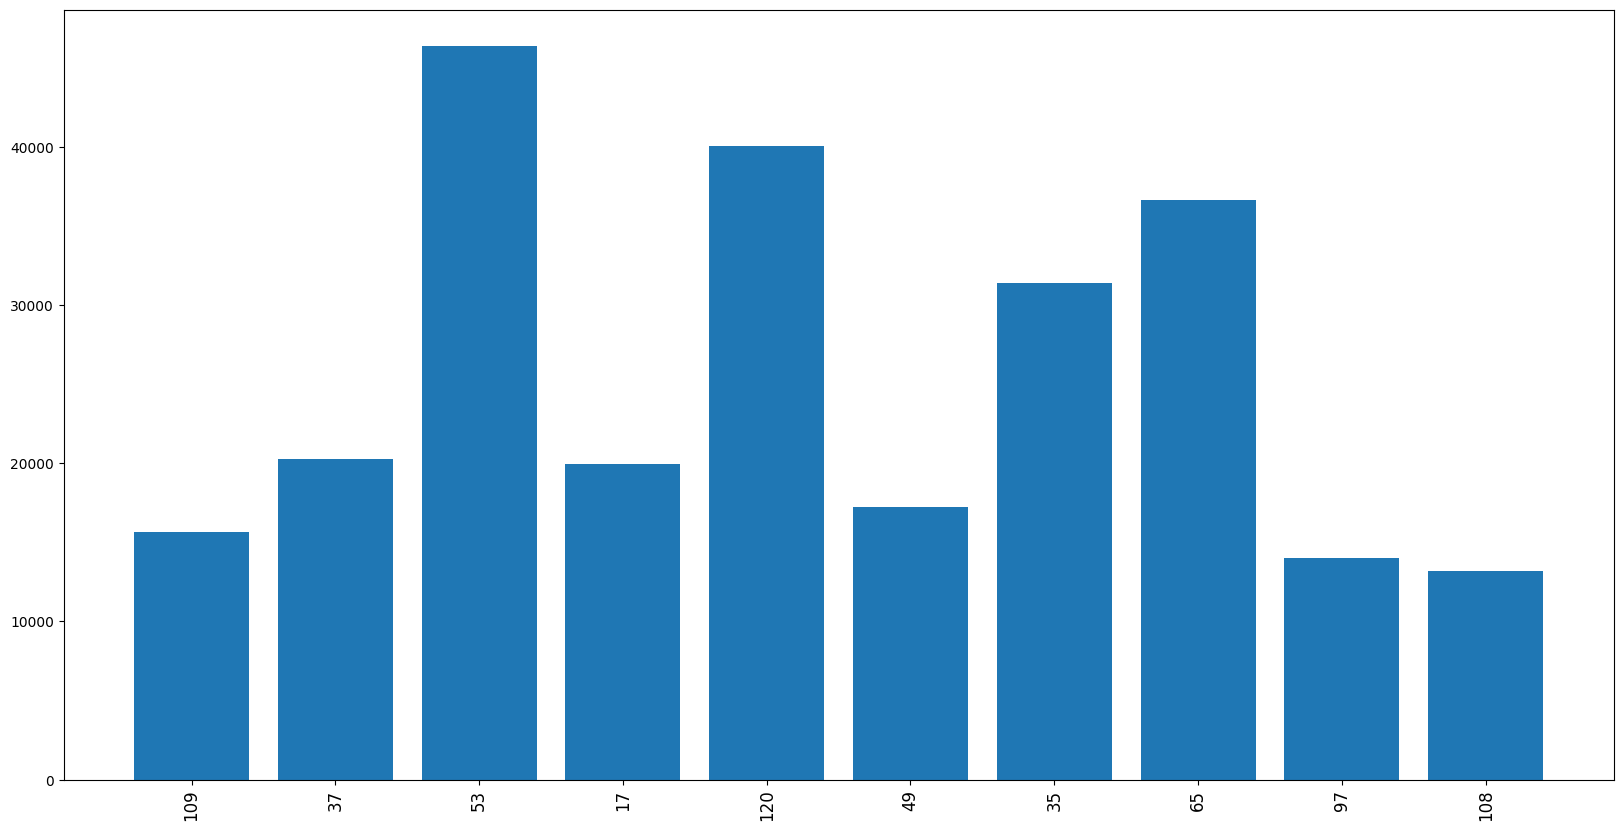

In [28]:
counter = Counter(tr_d_finetune['primary_cat'])
classes_ids, frequencies = list(counter.keys()), list(counter.values())
print(f"There are {len(classes_ids)} classes for {len(tr_d)} samples.")

fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.bar(range(len(frequencies)), frequencies)
ax.set_xticks(range(len(frequencies)))
ax.set_xticklabels(classes_ids, rotation=90, fontsize=12)
plt.show()
plt.close()

In [ ]:
# filter by class frequency
threshold = 40000
filtered_classes = [class_id for class_id, freq in counter.items() if freq > threshold]
d_filtered = dall.filter(lambda el: el['primary_cat'] in filtered_classes)
print(f"{len(filtered_classes)} classes left for {len(d_filtered)} samples") 

In [15]:
# select most K represented classes
num_cls = 10
out_id, out = [], []
for i, (k,v) in enumerate(sorted(counter.items(), reverse=True, key=lambda x:x[1])):
    print(k, v)
    out.append(k)
    out_id.append(classes[k])
    if i == num_cls-1:
        break
print(out_id, out)

53 109074
120 94188
65 86157
35 73851
37 47675
17 46934
49 40554
109 36869
97 33022
108 31088
['hep-ph', 'astro-ph', 'hep-th', 'quant-ph', 'cond-mat.mes-hall', 'gr-qc', 'cond-mat.mtrl-sci', 'cond-mat.str-el', 'cond-mat.stat-mech', 'astro-ph.SR'] [53, 120, 65, 35, 37, 17, 49, 109, 97, 108]


In [12]:
print(filtered_classes, [classes[idx] for idx in filtered_classes])

[65, 53, 17, 120, 37, 49, 35] ['hep-th', 'hep-ph', 'gr-qc', 'astro-ph', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'quant-ph']


## Compute token frequencies in abstracts

### Train tokenizer on generic corpus (need to do it only once, then load from disk)

In [16]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents

In [44]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [45]:
wiki_file = os.path.join(cache_dir, 'wikitext-103-raw', 'wiki.train.raw')
# tokenizer.train([wiki_file], trainer)
# tokenizer.save(os.path.join(cache_dir, 'mytokenizer', 'mytokenizer.json'))

In [56]:
custom_tokenizer = False
if custom_tokenizer:
    tokenizer = Tokenizer.from_file(os.path.join(cache_dir, 'mytokenizer', 'mytokenizer.json'))
else:
    tokenizer = AutoTokenizer.from_pretrained("roberta-base", cache_dir=cache_dir)

### Domain corpus frequencies and unknowns

In [57]:
from collections import defaultdict
domain_seen_tokens = defaultdict(float)
N_domain = tr_d.num_rows
unks = set()
unks_freq = 0
for abstract in tr_d['abstract']:
    if custom_tokenizer:
        out = tokenizer.encode(abstract, max_length=512, truncation=True)
        for idx, i in enumerate(out.ids):
            if i == 0: # [UNK]
                unks_freq += 1
                start, end = out.offsets[idx]
                unks.add(abstract[start:end])
            domain_seen_tokens[i] += 1
    else:
        out = tokenizer.encode(abstract, truncation=True, max_length=512)
        for idx, i in enumerate(out):
            if i == 3: # [UNK]
                unks_freq += 1
            domain_seen_tokens[i] += 1 

print("Number of times encountered unknowns: ", unks_freq)
if custom_tokenizer:
    print(f"Unknown tokens: {unks}")

Number of times encountered unknowns:  0


In [58]:
domain_seen_tokens

defaultdict(float,
            {0: 100000.0,
             250: 11917.0,
             3220: 200.0,
             536: 479.0,
             6: 452255.0,
             5: 1011513.0,
             16733: 176.0,
             9: 617305.0,
             39342: 3911.0,
             17325: 3221.0,
             20234: 2530.0,
             58: 7853.0,
             4976: 30.0,
             4: 597694.0,
             286: 11203.0,
             10: 308922.0,
             467: 23652.0,
             11: 275385.0,
             19: 133693.0,
             17210: 7748.0,
             11824: 1070.0,
             203: 4084.0,
             16: 191453.0,
             6238: 1369.0,
             149: 8933.0,
             17001: 909.0,
             329: 9100.0,
             4621: 2197.0,
             3724: 5712.0,
             4553: 1590.0,
             45152: 15081.0,
             12: 421141.0,
             725: 11276.0,
             10975: 1461.0,
             347: 9864.0,
             742: 4957.0,
             73: 

### Generic corpus frequencies

In [59]:
with open(wiki_file, 'r') as f:
    text = f.readlines()

In [60]:
generic_seen_tokens = defaultdict(float)
N_generic = len(text)
unks_generic = set()
unks_freq = 0
for t in text:
    if custom_tokenizer:
        out = tokenizer.encode(t)
        for idx, i in enumerate(out.ids):
            if i == 0: # [UNK]
                unks_freq += 1
                start, end = out.offsets[idx]
                unks_generic.add(abstract[start:end])
            generic_seen_tokens[i] += 1
    else:
        out = tokenizer.encode(t, truncation=True, max_length=512)
        for idx, i in enumerate(out):
            if i == 3: # [UNK]
                unks_freq += 1
            generic_seen_tokens[i] += 1
            
print("Number of unknowns: ", unks_freq)
if custom_tokenizer:
    print("Unknowns: ", unks_generic)

Number of unknowns:  0


In [61]:
generic_seen_tokens

defaultdict(float,
            {0: 1801350.0,
             1437: 1812177.0,
             50118: 1799892.0,
             2: 1801350.0,
             5457: 1466599.0,
             468: 41686.0,
             44068: 251.0,
             6374: 3355.0,
             41674: 621.0,
             6395: 8833.0,
             2211: 1881.0,
             267: 22575.0,
             38183: 7408.0,
             117: 61007.0,
             155: 87123.0,
             4832: 181106.0,
             1890: 6901.0,
             36902: 176.0,
             36: 583020.0,
             2898: 19270.0,
             47416: 971.0,
             23133: 1451.0,
             18164: 947.0,
             42393: 554.0,
             21402: 2798.0,
             20024: 1533.0,
             48018: 356.0,
             50033: 15.0,
             49080: 529.0,
             49587: 70.0,
             49432: 134.0,
             48947: 374.0,
             49017: 321.0,
             246: 9592.0,
             2156: 4966954.0,
             6474: 

### Compute normalized frequencies without stopwords

In [62]:
# spacy english stopwords
stop = ['those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing', 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby', 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without', 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about', 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after', 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve']
domain_seen_tokens_stop = {k: v for k, v in domain_seen_tokens.items() 
                           if tokenizer.decode([k]).lower() not in stop}
generic_seen_tokens_stop = {k: v for k, v in generic_seen_tokens.items() 
                            if tokenizer.decode([k]).lower() not in stop}

n_tokens_generic = sum(generic_seen_tokens_stop.values())
n_tokens_domain = sum(domain_seen_tokens_stop.values())

In [63]:
domain_seen_tokens_norm = {k: v / n_tokens_domain for k, v in domain_seen_tokens_stop.items()}
generic_seen_tokens_norm = {k: v / n_tokens_generic for k, v in generic_seen_tokens_stop.items()}
sorted_generic_norm = dict(sorted(generic_seen_tokens_norm.items(), key=lambda x:x[1], reverse=True))
sorted_domain_norm = dict(sorted(domain_seen_tokens_norm.items(), key=lambda x:x[1], reverse=True))

In [70]:
# compute number of tokens present in both generic and domain dictionary 
# in the first n_first positions (order does not matter)

n_first = 1000
a, b = list(sorted_domain_norm.keys())[:n_first], list(sorted_generic_norm.keys())[:n_first]
aset, bset = set(a), set(b)
print(f"Number of tokens occurring in both corpus in first {n_first} positions: {len(aset.intersection(bset))}, vs. {len(sorted_domain_norm)} tokens in domain corpus and {len(sorted_generic_norm)} tokens in generic corpus.")

Number of tokens occurring in both corpus in first 1000 positions: 343, vs. 32633 tokens in domain corpus and 46490 tokens in generic corpus.


### Retrieve tokens occurring mostly in domain corpus

In [71]:
domain_tokens = aset.difference(bset)

In [72]:
tokenizer.decode(list(domain_tokens))

' transitions description binary$,ole mon solar < Hamilton exchange:netropy) detected describe corresponding respect pert reson spectral graphene devices derive cross trans/ dwarf degrees our flux{order ~\' metal - diagram" equationsym physical specific radial;1 density spinities transport emission highly relevant lumin interactionerm independent galaxy detailed paper zero direct spatial massiveopygamilibrium conform consistent us motionqu% regime dimensions dustices discuss galaxies observediral increasing),type sp53 predictions layer lines here compact phase correlation report components dependence fluctuations construct exc therm entropy gaugetimes stableology0 induced exhibit shown simulations resonanceome methods et4 neut fundamentalally).iton particles effective particle linear information allows functionalance bulkC noise quantries absorptionigenFe fixedrm algebra super tunnel distance negative spectrum detectionBability holes8ature6 measure7yr^ dataice electron expected solutio

In [73]:
print(domain_tokens)

{28672, 8194, 32771, 47110, 4104, 6154, 4118, 28696, 4127, 2081, 35, 4135, 47145, 43, 12333, 6190, 12337, 2098, 32819, 18482, 45113, 38970, 2110, 34882, 2116, 6214, 73, 30794, 4176, 84, 34903, 45152, 10337, 14434, 108, 4204, 111, 41071, 113, 43123, 8307, 2166, 2167, 45174, 131, 134, 16522, 6287, 2192, 4240, 22679, 2200, 4249, 30878, 10405, 8362, 2222, 22703, 4271, 2225, 4276, 2228, 34999, 2232, 16572, 32959, 47295, 18627, 4292, 201, 4298, 2253, 207, 4304, 22735, 8402, 6355, 2268, 30948, 6373, 24811, 2284, 238, 12528, 2292, 245, 246, 12535, 10490, 2301, 259, 12549, 4359, 22792, 266, 6411, 20748, 22798, 12558, 12562, 26898, 47382, 12567, 14616, 4375, 4383, 288, 26914, 8483, 2343, 31016, 35114, 4399, 6448, 4400, 306, 28979, 6451, 2368, 322, 24899, 16710, 2375, 33100, 26956, 335, 2386, 12628, 2389, 8533, 347, 6496, 24934, 4458, 33131, 8554, 29037, 4460, 22900, 45429, 2422, 10615, 4472, 2430, 8576, 12673, 387, 4484, 6538, 398, 18830, 401, 2450, 406, 4503, 35227, 414, 2463, 35235, 421, 2472,

### Frequencies of domain tokens in generic corpus

In [75]:
from math import inf

print("Domain frequencies - generic frequencies. Domain ranking - generic ranking")
tokenid2rank = {}  # token id -> ranking
for t in domain_tokens:
    tokenname = tokenizer.decode([t])
    df = sorted_domain_norm[t]
    pf = list(sorted_domain_norm.keys()).index(t)
    try:
        dg = sorted_generic_norm[t]
        pg = list(sorted_generic_norm.keys()).index(t)
    except KeyError:
        dg = 0
        pg = inf
        
    assert pf < 1000 and pg >= 1000
    print(f"{t}-{tokenname}: {df:.4f} - {dg:.4f}. {pf} - {pg} = {pg-pf}")
    tokenid2rank[t] = pg-pf

Domain frequencies - generic frequencies. Domain ranking - generic ranking
28672- transitions: 0.0003 - 0.0000. 585 - 18777 = 18192
8194- description: 0.0002 - 0.0000. 672 - 3100 = 2428
32771- binary: 0.0003 - 0.0000. 495 - 12732 = 12237
47110-$,: 0.0008 - 0.0000. 140 - inf = inf
4104-ole: 0.0002 - 0.0000. 650 - 3009 = 2359
6154- mon: 0.0002 - 0.0000. 830 - 2145 = 1315
4118- solar: 0.0004 - 0.0000. 288 - 5778 = 5490
28696- <: 0.0002 - 0.0000. 692 - 3525 = 2833
4127- Hamilton: 0.0003 - 0.0000. 477 - 3338 = 2861
2081- exchange: 0.0002 - 0.0000. 679 - 3053 = 2374
35-:: 0.0007 - 0.0000. 166 - inf = inf
4135-net: 0.0002 - 0.0000. 740 - 6484 = 5744
47145-ropy: 0.0002 - 0.0000. 812 - 35320 = 34508
43-): 0.0056 - 0.0000. 14 - inf = inf
12333- detected: 0.0002 - 0.0000. 750 - 8079 = 7329
6190- describe: 0.0002 - 0.0000. 592 - 4669 = 4077
12337- corresponding: 0.0003 - 0.0000. 411 - 8050 = 7639
2098- respect: 0.0002 - 0.0000. 936 - 3916 = 2980
32819- pert: 0.0004 - 0.0000. 306 - 24106 = 23800
18

3953- weak: 0.0004 - 0.0000. 361 - 3419 = 3058
1907- type: 0.0004 - 0.0001. 379 - 1134 = 755
8056-scale: 0.0002 - 0.0000. 980 - 37985 = 37005
22396- magnet: 0.0006 - 0.0000. 180 - 11705 = 11525
1916-ma: 0.0003 - 0.0001. 565 - 2031 = 1466
8066- existence: 0.0002 - 0.0000. 689 - 3029 = 2340
3971- temperatures: 0.0003 - 0.0000. 484 - 4068 = 3584
8069- studied: 0.0004 - 0.0000. 308 - 3237 = 2929
44937- diffusion: 0.0002 - 0.0000. 848 - 17728 = 16880
1933- unit: 0.0002 - 0.0001. 901 - 1485 = 584
6029- signal: 0.0002 - 0.0000. 959 - 5467 = 4508
1938-ization: 0.0010 - 0.0001. 92 - 2092 = 2000
8085- demonstrate: 0.0003 - 0.0000. 384 - 9280 = 8896
10134- rotation: 0.0002 - 0.0000. 613 - 8145 = 7532
3994-ark: 0.0003 - 0.0000. 444 - 3262 = 2818
10138- Monte: 0.0002 - 0.0000. 914 - 5927 = 5013
14237- ren: 0.0002 - 0.0000. 670 - 5329 = 4659
34719-igma: 0.0002 - 0.0000. 635 - 19437 = 18802
26534- theoretical: 0.0003 - 0.0000. 426 - 11208 = 10782
1966- analysis: 0.0006 - 0.0000. 195 - 2747 = 2552
101

In [77]:
## filter by ranking, higher is better
thresh_rank = 1000
sortedtokenid2rank = dict(sorted(tokenid2rank.items(), reverse=True, key=lambda item: item[1]))
print(sortedtokenid2rank)
rankfiltered = [k for k, v in sortedtokenid2rank.items() if v > thresh_rank]
rankdecodedfiltered = [tokenizer.decode([k]) for k in rankfiltered]
print()
print(rankfiltered)
print(rankdecodedfiltered)
print(len(rankfiltered))

{47110: inf, 35: inf, 43: inf, 73: inf, 45152: inf, 113: inf, 131: inf, 207: inf, 238: inf, 322: inf, 35227: inf, 482: inf, 49688: inf, 41552: inf, 37457: inf, 49747: inf, 49830: inf, 2744: inf, 742: inf, 49918: inf, 49959: inf, 5214: inf, 48292: inf, 1215: inf, 1358: inf, 1629: inf, 1640: inf, 34437: inf, 24303: inf, 10068: inf, 29135: 44915, 18261: 41416, 23944: 40503, 38970: 39631, 14616: 39527, 43879: 38624, 29037: 38389, 30231: 37969, 46246: 37620, 8056: 37005, 47295: 36356, 805: 35311, 44128: 34959, 32959: 34754, 47145: 34508, 37836: 34231, 47382: 33910, 43808: 33864, 34746: 31856, 37357: 31210, 48375: 30811, 40764: 30424, 43871: 30169, 46883: 29663, 26545: 29395, 40584: 29324, 41647: 28988, 24899: 28186, 21349: 28029, 44650: 28024, 23554: 27917, 26070: 27169, 24934: 27147, 22187: 27001, 43797: 26892, 31016: 26715, 5579: 26700, 11615: 26539, 9773: 26240, 22798: 26136, 43437: 25647, 12528: 25469, 46194: 25457, 44030: 25212, 22792: 24603, 44635: 24159, 13092: 24055, 32819: 23800, 1

## Explore tokenizer with new tokens

In [37]:
# byte-level BPE tokenizer
#input_str = "hellohow areyou today?"
input_str = 'this is ferro magnetic'
pretrained_tokenizer = AutoTokenizer.from_pretrained("roberta-base", cache_dir=cache_dir)

In [38]:
type(pretrained_tokenizer)

transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast

In [39]:
tokens = pretrained_tokenizer.tokenize(input_str)
print(tokens)
ids = pretrained_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
print(pretrained_tokenizer(input_str))

['this', 'Ġis', 'Ġfer', 'rom', 'agnetic']
[9226, 16, 16022, 5638, 44650]
{'input_ids': [0, 9226, 16, 16022, 5638, 44650, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [40]:
pretrained_tokenizer.add_tokens(["ferromagnetic", "magnetic"])  # this is case-sensitive, will not convert Hellohow

2

In [43]:
tokens = pretrained_tokenizer.tokenize(input_str)
print(tokens)
ids = pretrained_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
print(pretrained_tokenizer(input_str))

['this', 'Ġis', 'Ġfer', 'ro', 'Ġ', 'magnetic']
[9226, 16, 16022, 1001, 1437, 50266]
{'input_ids': [0, 9226, 16, 16022, 1001, 1437, 50266, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


## Get domain words by TF-IDF

TF-IDF is computed with: TF considering a single document (union of all abstracts), IDF considering separate abstracts

In [9]:
from datasets import concatenate_datasets
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers import Tokenizer

# tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
# tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
# tokenizer.pre_tokenizer = Whitespace()
# trainer = WordLevelTrainer(special_tokens=["[UNK]"])

def batch_iterator(batch_size=1000):
    for i in range(0, len(tr_d), batch_size):
        yield tr_d[i : i + batch_size]["abstract"]
        
# tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(tr_d))

In [10]:
# tokenizer.save(os.path.join(cache_dir, 'mywordleveltokenizer', 'mytokenizer.json'))

In [12]:
tokenizer = Tokenizer.from_file(os.path.join(cache_dir, 'mywordleveltokenizer', 'mytokenizer.json'))

In [13]:
from collections import defaultdict
domain_seen_words = defaultdict(float)
N_domain = tr_d.num_rows
unks = set()
unks_freq = 0
for abstract in tr_d['abstract']:
    out = tokenizer.encode(abstract)
    for idx, i in enumerate(out.ids):
        if i == 0: # [UNK]
            unks_freq += 1
            start, end = out.offsets[idx]
            unks.add(abstract[start:end])
        domain_seen_words[i] += 1 

print("Number of times encountered unknowns: ", unks_freq)
print(f"Unknown tokens: {unks}")

Number of times encountered unknowns:  127740
Unknown tokens: {'Dikii', ')^+', '1701117', 'Broydens', 'secularities', 'disputable', 'DRSR', '004332', 'M_g_0', '2xF1', '033816', "*)'", '2908', 'strives', ';<\\', '2NiO4', '787', 'RDPs', 'Rehborn', 'industrially', 'Fok', 'Calderon', 'Delta_a', '1055', 'GeH4', 'Feddersen', '=[(\\', 'Ce3Pd20Si6', 'cokernels', '6741', 'PICASSO', '2589', 'chi_4', '13426', 'absolutist', '625A', 'ley', 'mirages', '68m', 'pours', 'redetected', '0002159', '0505176', '6347', 'protospot', 'lion', 'potentialexperimental', 'reaccelerating', 'shareholders', '5836', 'hydrocode', 'macroion', 'D_0T', 'Nogaret', 'MgV_2O_4', 'ethode', 'nonstatistical', 'orthorhombical', 'C4668', 'lowenergy', '1351', 'rifling', '3705', 'Kajantie', 'B3PW', 'KORALZ', 'dissection', 'MnV2O6', 'FINFETs', 'D4000', 'RRE', 'coprocessors', '^{+}}=', 'Carmer', 'printers', 'ProtoEXIST1', '44x', 'WISEPC', 'CdCu', 'Akhiezer', 'Refsdal', 'Incorrigibly', 'immeasurably', 'covariants', 'transiton', 'repacka

In [14]:
domain_seen_words

defaultdict(float,
            {7: 331274.0,
             4941: 221.0,
             3126: 480.0,
             4: 448733.0,
             1: 1122169.0,
             5508: 181.0,
             2: 620079.0,
             361: 5748.0,
             637: 3386.0,
             797: 2732.0,
             245: 7863.0,
             12986: 30.0,
             3: 597588.0,
             12: 148966.0,
             62: 23944.0,
             8: 314346.0,
             13: 136783.0,
             238: 8024.0,
             1712: 1185.0,
             511: 4182.0,
             11: 189394.0,
             1495: 1413.0,
             193: 9394.0,
             1867: 1043.0,
             413: 5154.0,
             3970: 322.0,
             2682: 613.0,
             190: 9504.0,
             244: 7888.0,
             225: 8399.0,
             10437: 48.0,
             5360: 190.0,
             991: 2221.0,
             558: 3856.0,
             1358: 1563.0,
             270: 7431.0,
             1109: 1984.0,
          

In [15]:
sorted_domain_words = dict(sorted(domain_seen_words.items(), key=lambda x:x[1], reverse=True))
sorted_domain_words

{1: 1122169.0,
 2: 620079.0,
 3: 597588.0,
 4: 448733.0,
 5: 408690.0,
 6: 334685.0,
 7: 331274.0,
 8: 314346.0,
 9: 260029.0,
 10: 204481.0,
 11: 189394.0,
 12: 148966.0,
 13: 136783.0,
 14: 136031.0,
 15: 132078.0,
 16: 129394.0,
 0: 127740.0,
 17: 101558.0,
 18: 98941.0,
 19: 91982.0,
 20: 87391.0,
 21: 80337.0,
 22: 76545.0,
 23: 65794.0,
 24: 65412.0,
 25: 63796.0,
 26: 63136.0,
 27: 58852.0,
 28: 46725.0,
 29: 45758.0,
 30: 44970.0,
 31: 44330.0,
 32: 44182.0,
 33: 44015.0,
 34: 41868.0,
 35: 41713.0,
 36: 36321.0,
 37: 35873.0,
 38: 35395.0,
 39: 35054.0,
 40: 34891.0,
 41: 33612.0,
 42: 33450.0,
 43: 33355.0,
 44: 32260.0,
 45: 30381.0,
 46: 30286.0,
 47: 30066.0,
 48: 29304.0,
 49: 28985.0,
 50: 28639.0,
 51: 27895.0,
 52: 27566.0,
 53: 27479.0,
 54: 27140.0,
 55: 26950.0,
 56: 26429.0,
 57: 25560.0,
 58: 25460.0,
 59: 25103.0,
 60: 24863.0,
 61: 24781.0,
 62: 23944.0,
 63: 23153.0,
 64: 22719.0,
 65: 22608.0,
 66: 21827.0,
 67: 21556.0,
 68: 21267.0,
 69: 21032.0,
 70: 20912.

In [16]:
from math import log

## IDF computation
idf = defaultdict(float)
for abstract in tr_d['abstract']:
    out = tokenizer.encode(abstract)
    setids = list(set(out.ids))
    for k in setids:
            idf[k] += 1
        
idf = dict([(k, log(float(len(tr_d)) / v)) for k, v in idf.items()])
idf

{1: 0.006390375022014352,
 2: 0.017146158834970584,
 3: 0.0023126721659287573,
 4: 0.10093698059804694,
 5: 0.12777655494215853,
 6: 0.08766249801383239,
 7: 0.11054057569936858,
 8: 0.09440958546117866,
 11: 0.2616505192442245,
 12: 0.3734287949087108,
 13: 0.3948367893189851,
 14: 0.39271671528599794,
 2063: 5.005647752585217,
 17: 0.5754530377433023,
 21: 0.6688644080401043,
 24: 0.8348259588918833,
 26: 0.9029797178144827,
 32: 1.3265925178738467,
 38: 1.3254250633567037,
 44: 1.6271437395530326,
 45: 1.488725837271837,
 558: 3.5751936897101197,
 47: 1.4591231517752323,
 49: 1.4413843274378506,
 52: 1.5555654469696107,
 3126: 5.408132232555244,
 59: 1.7464611086007682,
 7228: 6.897804948128969,
 62: 1.8453501374011312,
 65: 2.036688612614187,
 81: 1.9244911816820134,
 83: 1.9262055657809778,
 1108: 4.1844881120750665,
 1109: 4.06052301374659,
 2656: 5.112668019661408,
 2148: 4.8472417471878195,
 2161: 4.824570751023467,
 2682: 5.640807675494813,
 637: 3.5935692743096115,
 136: 2.26

In [17]:
tfidf = {}
for k, tf in domain_seen_words.items():
    tfidf[k] = tf * idf[k]
tfidf

{7: 36619.21867423262,
 4941: 1380.159874605425,
 3126: 2595.903471626517,
 4: 45293.7541147034,
 1: 7171.0807480788235,
 5508: 1151.0937305555133,
 2: 10631.973024229725,
 361: 18590.430499892107,
 637: 12167.825562812344,
 797: 10612.202214495612,
 245: 22588.880864773353,
 12986: 243.3518424992422,
 3: 1382.0251342930342,
 12: 55628.19386237101,
 62: 44185.063689932686,
 8: 29677.275551379666,
 13: 54006.960553418736,
 238: 23962.682457326846,
 1712: 5838.203264986932,
 511: 13580.105302048556,
 11: 49555.03844174065,
 1495: 6062.277897407205,
 193: 23552.188318559594,
 1867: 4990.021616516605,
 413: 16450.264849651652,
 3970: 1920.3595003841529,
 2682: 3457.8151050783204,
 190: 28891.144681405083,
 244: 23931.005610622236,
 225: 25815.95435238408,
 10437: 379.29636251164817,
 5360: 1265.570088199616,
 991: 9022.28982931305,
 558: 13785.946867522222,
 1358: 6589.349260682734,
 270: 20365.58472451254,
 1109: 8056.077659273235,
 899: 9446.87986297706,
 666: 11254.285016317726,
 3505: 

In [18]:
sorted_tfidf = dict(sorted(tfidf.items(), key=lambda x:x[1], reverse=True))
sorted_tfidf

{15: 183183.54360911399,
 0: 90699.08886658167,
 30: 86329.2005656337,
 16: 81060.29041121584,
 19: 73892.9654753328,
 42: 72767.93103977291,
 28: 71572.5451561555,
 40: 68955.34507959822,
 37: 67099.65922897025,
 41: 66918.73498550811,
 29: 65218.17733971778,
 43: 63852.60942327408,
 35: 62399.75610614041,
 33: 62043.717003400976,
 25: 61944.9296051828,
 22: 61387.58862315728,
 32: 58611.51062470229,
 17: 58441.85960713429,
 39: 57992.74092754219,
 26: 57010.52746393518,
 20: 56256.08979061918,
 12: 55628.19386237101,
 18: 54943.67259236807,
 24: 54607.635623035865,
 13: 54006.960553418736,
 21: 53734.559948717855,
 14: 53421.647497069585,
 23: 53270.67300426349,
 44: 52491.65703798083,
 53: 52377.542178683834,
 27: 52250.262749830166,
 5: 52221.00023931077,
 34: 51814.33203565272,
 57: 51742.32157270396,
 76: 51168.17624598525,
 31: 50986.0483225835,
 61: 50813.54685472999,
 11: 49555.03844174065,
 55: 48602.91036817648,
 51: 47428.146730236855,
 36: 47326.98789187275,
 10: 47242.702

In [19]:
limit = 1000
words = list(sorted_tfidf.keys())[:limit+1]
words.remove(0)
print(words)

[15, 30, 16, 19, 42, 28, 40, 37, 41, 29, 43, 35, 33, 25, 22, 32, 17, 39, 26, 20, 12, 18, 24, 13, 21, 14, 23, 44, 53, 27, 5, 34, 57, 76, 31, 61, 11, 55, 51, 36, 10, 58, 80, 56, 38, 78, 65, 63, 4, 45, 50, 62, 47, 59, 82, 95, 52, 67, 49, 46, 60, 75, 48, 54, 70, 74, 114, 71, 9, 84, 85, 66, 89, 68, 116, 118, 69, 64, 113, 7, 115, 101, 73, 79, 81, 86, 87, 83, 127, 107, 100, 88, 72, 94, 97, 77, 146, 93, 91, 90, 125, 98, 141, 108, 103, 110, 92, 109, 124, 96, 99, 159, 154, 102, 119, 126, 104, 130, 117, 203, 129, 171, 105, 120, 106, 122, 185, 163, 144, 8, 151, 173, 112, 6, 123, 179, 131, 111, 190, 121, 156, 133, 149, 165, 150, 138, 137, 157, 145, 155, 172, 128, 169, 143, 132, 139, 147, 192, 153, 205, 178, 162, 161, 136, 202, 142, 135, 201, 140, 176, 134, 148, 170, 174, 183, 194, 181, 164, 196, 158, 198, 166, 195, 189, 242, 225, 167, 160, 168, 199, 200, 237, 223, 184, 152, 218, 229, 213, 207, 300, 188, 182, 175, 311, 230, 177, 197, 238, 244, 191, 209, 210, 180, 247, 219, 187, 193, 186, 236, 217, 2

In [36]:
pretr = AutoTokenizer.from_pretrained("roberta-base", cache_dir=cache_dir)

In [20]:
toadd, toaddwords = [], []
for el in words:
    if tokenizer.decode([el]) not in pretr.vocab:
        toadd.append(el)
        toaddwords.append(tokenizer.decode([el]))

In [21]:
print(len(toaddwords), toaddwords)

426 ['quantum', '$\\', 'magnetic', 'theory', 'temperature', '}$', 'systems', 'transition', 'electron', 'observed', 'structure', 'emission', 'coupling', 'solar', 'symmetry', 'obtained', 'distribution', 'interaction', 'potential', 'evolution', 'parameters', 'dynamics', 'optical', 'gauge', 'observations', 'particle', 'lattice', 'equation', 'topological', 'approach', 'equations', 'classical', 'solutions', 'parameter', 'spectrum', 'graphene', 'discuss', 'galaxies', 'scattering', 'thermal', 'measurements', 'finite', 'scalar', 'possible', 'spectra', 'gravitational', 'velocity', 'interactions', 'particles', 'flux', 'simulations', 'experimental', 'gamma', 'spectral', 'transport', 'modes', 'cluster', 'functions', 'particular', 'however', 'entanglement', 'presence', 'numerical', 'investigate', 'electronic', ')$', 'constant', 'correlation', 'calculations', '$-', 'conditions', 'consistent', 'theories', 'studied', 'entropy', 'momentum', 'dependence', 'solution', 'provide', 'photon', 'boundary', '_2'

In [45]:
# sort by length to avoid adding substrings before superstrings
toaddwords_sorted = list(sorted(toaddwords, key=lambda x: len(x), reverse=True))
toaddwords_sorted

['antiferromagnetic',
 'renormalization',
 'superconducting',
 'electromagnetic',
 'supersymmetric',
 'experimentally',
 'characteristic',
 'representation',
 'configurations',
 'gravitational',
 'corresponding',
 'approximation',
 'ferromagnetic',
 'magnetization',
 'distributions',
 'significantly',
 'thermodynamic',
 'understanding',
 'contributions',
 'characterized',
 'perturbations',
 'configuration',
 'spectroscopic',
 'observational',
 'distribution',
 'observations',
 'measurements',
 'interactions',
 'experimental',
 'entanglement',
 'calculations',
 'fluctuations',
 'cosmological',
 'polarization',
 'temperatures',
 'correlations',
 'investigated',
 'relativistic',
 'applications',
 'contribution',
 'oscillations',
 'conductivity',
 'respectively',
 'spectroscopy',
 'perturbation',
 'differential',
 'intermediate',
 'perturbative',
 'temperature',
 'interaction',
 'topological',
 'simulations',
 'investigate',
 'correlation',
 'theoretical',
 'equilibrium',
 'demonstrate',
 

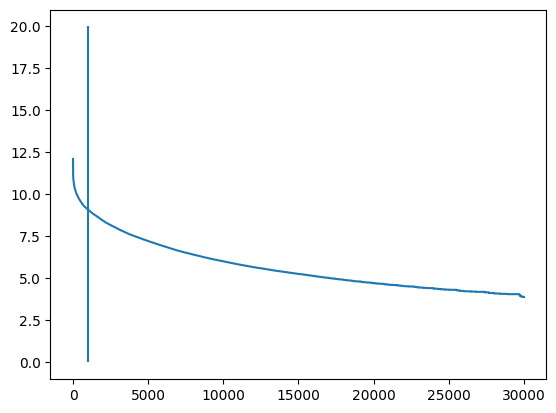

In [22]:
# log distribution of frequencies
import matplotlib.pyplot as plt
plt.close()
plt.plot(range(len(sorted_tfidf)), np.log(np.array(list(sorted_tfidf.values()))))
plt.vlines(limit, 0, 20)
plt.show()

### Are new tokens substrings of existing/new tokens?

In [62]:
# tf-idf word
additional_tokens_word = ['antiferromagnetic', 'renormalization', 'superconducting', 'electromagnetic', 'supersymmetric',
                     'experimentally', 'characteristic', 'representation', 'configurations', 'gravitational',
                     'corresponding', 'approximation', 'ferromagnetic', 'magnetization', 'distributions',
                     'significantly', 'thermodynamic', 'understanding', 'contributions', 'characterized',
                     'perturbations', 'configuration', 'spectroscopic', 'observational', 'distribution', 'observations',
                     'measurements', 'interactions', 'experimental', 'entanglement', 'calculations', 'fluctuations',
                     'cosmological', 'polarization', 'temperatures', 'correlations', 'investigated', 'relativistic',
                     'applications', 'contribution', 'oscillations', 'conductivity', 'respectively', 'spectroscopy',
                     'perturbation', 'differential', 'intermediate', 'perturbative', 'temperature', 'interaction',
                     'topological', 'simulations', 'investigate', 'correlation', 'theoretical', 'equilibrium',
                     'demonstrate', 'experiments', 'transitions', 'hamiltonian', 'measurement', 'corrections',
                     'constraints', 'probability', 'interacting', 'generalized', 'predictions', 'fundamental',
                     'statistical', 'excitations', 'calculation', 'possibility', 'furthermore', 'conductance',
                     'instability', 'frequencies', 'metallicity', 'observation', 'anisotropic', 'numerically',
                     'observables', 'variability', 'transition', 'parameters', 'scattering', 'particular', 'electronic',
                     'conditions', 'consistent', 'dependence', 'structures', 'dimensions', 'considered', 'calculated',
                     'determined', 'absorption', 'luminosity', 'relaxation', 'components', 'previously', 'anisotropy',
                     'analytical', 'additional', 'excitation', 'transverse', 'correlated', 'comparison', 'dispersion',
                     'simulation', 'continuous', 'relativity', 'mechanical', 'techniques', 'amplitudes', 'difference',
                     'variations', 'experiment', 'asymptotic', 'structural', 'abundances', 'statistics', 'introduced',
                     'stochastic', 'symmetries', 'approaches', 'structure', 'potential', 'evolution', 'equations',
                     'classical', 'solutions', 'parameter', 'particles', 'transport', 'functions', 'numerical',
                     'discussed', 'dynamical', 'materials', 'processes', 'electrons', 'molecular', 'mechanism',
                     'agreement', 'presented', 'radiation', 'expansion', 'amplitude', 'spacetime', 'accretion',
                     'determine', 'calculate', 'diffusion', 'symmetric', 'magnitude', 'invariant', 'formalism',
                     'resulting', 'detection', 'arbitrary', 'operators', 'resonance', 'nonlinear', 'technique',
                     'insulator', 'conformal', 'tunneling', 'predicted', 'continuum', 'performed', 'algorithm',
                     'therefore', 'stability', 'abundance', 'variables', 'couplings', 'curvature', 'anomalous',
                     'mechanics', 'principle', 'increases', 'phenomena', 'behaviour', 'telescope', 'polarized',
                     'radiative', 'localized', 'influence', 'introduce', 'entangled', 'inflation', 'intrinsic',
                     'densities', 'magnetic', 'electron', 'observed', 'emission', 'coupling', 'symmetry', 'obtained',
                     'dynamics', 'particle', 'equation', 'approach', 'spectrum', 'graphene', 'galaxies', 'possible',
                     'velocity', 'spectral', 'presence', 'constant', 'theories', 'momentum', 'solution', 'boundary',
                     'clusters', 'neutrino', 'proposed', 'universe', 'recently', 'rotation', 'compared', 'strongly',
                     'previous', 'infrared', 'exchange', 'measured', 'describe', 'einstein', 'provides', 'geometry',
                     'extended', 'galactic', 'energies', 'addition', 'detected', 'increase', 'disorder', 'elements',
                     'scenario', 'fermions', 'coherent', 'estimate', 'detailed', 'contrast', 'rotating', 'metallic',
                     'redshift', 'identify', 'fraction', 'periodic', 'binaries', 'enhanced', 'suggests', 'gaussian',
                     'moreover', 'indicate', 'analyzed', 'exhibits', 'directly', 'hydrogen', 'infinite', 'profiles',
                     'surfaces', 'resolved', 'collapse', 'combined', 'impurity', 'examples', 'explicit', 'quantum',
                     'systems', 'optical', 'lattice', 'discuss', 'thermal', 'spectra', 'cluster', 'however', 'studied',
                     'entropy', 'provide', 'several', 'orbital', 'physics', 'sources', 'coupled', 'regions', 'scaling',
                     'various', 'applied', 'methods', 'further', 'spatial', 'propose', 'neutron', 'finally', 'studies',
                     'crystal', 'measure', 'horizon', 'diagram', 'analyze', 'compare', 'exhibit', 'compute', 'compact',
                     'fermion', 'degrees', 'explain', 'depends', 'coulomb', 'reduced', 'smaller', 'becomes', 'coronal',
                     'samples', 'observe', 'minimal', 'photons', 'kinetic', 'formula', 'appears', 'typical', 'towards',
                     'theory', 'finite', 'scalar', 'photon', 'regime', 'phases', 'matrix', 'obtain', 'masses', 'galaxy',
                     'derive', 'tensor', 'larger', 'vacuum', 'phonon', 'chiral', 'scheme', 'metric', 'scales', 'mixing',
                     'radial', 'signal', 'survey', 'plasma', 'cosmic', 'strain', 'cavity', 'dwarfs', 'layers', 'cannot',
                     'latter', 'doping', 'beyond', 'curves', 'reveal', 'appear', 'decays', 'moment', 'landau', 'occurs']#,
                     #'solar', 'gauge', 'gamma', 'modes', 'decay', 'noise', 'higgs', 'fermi', 'ratio', 'exact', 'delta',
                     #'quark', 'leads', 'dirac', 'atoms', 'qubit', 'sigma', 'quasi', 'dwarf', 'brane', 'films', 'monte',
                     #'carlo', 'means', 'boson', 'omega', 'novel', 'basis', 'spins', 'fluid', 'gives', 'probe', 'kondo',
                     #'giant', 'flare', 'doped', 'argue', 'disks', 'pairs', 'flux', 'bulk', 'dual', '^{-', 'qcd', 'tau',
                     #'}$,', '+/-', '}$.', 'gev', 'ngc', '$\\', '}$', ')$', '$-', '_2', '2d', '_3', 'm_', '3d', '$)']

In [63]:
len(pretr.vocab), len(toaddwords)

(50265, 419)

In [64]:
# are new tokens substrings of existing tokens?
subcounter = defaultdict(list)
forgotten = set()
vocab = list(pretr.vocab.keys())
for w in additional_tokens_word:
    for v in vocab:
        if (w in v) and (w != v[1:]) and (w != v[1:-1]) and (v != w[:-1]):
            subcounter[w].append(v)
            forgotten.add(v)
sorted_subcounter = dict(sorted(subcounter.items(), key=lambda x:len(x[1]), reverse=True))
print(sorted_subcounter)
print(forgotten)

{'strain': ['Ġrestrain', 'Ġstrained', 'Ġrestraints', 'Ġconstraint', 'Ġrestraint', 'Ġrestraining', 'Ġconstrained', 'Ġconstraints', 'Ġrestrained'], 'appear': ['Ġappearing', 'Ġdisappearing', 'Ġdisappeared', 'Ġappeared', 'Ġdisappearance', 'Ġappearance', 'Ġappearances', 'Ġdisappears', 'Ġdisappear'], 'finite': ['ĠDefinitely', 'Ġdefinitely', 'Ġinfinite', 'ĠInfinite', 'Ġinfinitely', 'Ġindefinitely', 'Ġindefinite', 'Ġdefinite'], 'evolution': ['Ġrevolutionary', 'ĠRevolutionary', 'Ġevolutionary', 'Ġrevolution', 'Ġrevolutionaries', 'Ġrevolutions', 'ĠRevolution'], 'solution': ['ĠResolution', 'Ġdissolution', 'Ġresolutions', 'resolution', 'Ġresolution'], 'discuss': ['Ġdiscussions', 'Ġdiscussed', 'Ġdiscusses', 'Ġdiscussing', 'Ġdiscussion'], 'experiment': ['Ġexperimentation', 'Ġexperimental', 'Ġexperimented', 'Ġexperimenting'], 'transport': ['Ġtransporter', 'Ġtransported', 'Ġtransportation', 'Ġtransporting'], 'sources': ['Ġresources', 'Resources', 'ĠResources', 'resources'], 'exhibit': ['Ġexhibition', 

In [30]:
# are new tokens substrings of new tokens?
subcounter2 = defaultdict(float)
conflicts = set()
for w in toaddwords:
    for v in toaddwords:
        if w in v:
            subcounter2[w] += 1
            conflicts.add(v)
    subcounter2[w] -= 1 # remove comparison with self
sorted_subcounter2 = dict(sorted(subcounter2.items(), key=lambda x:x[1], reverse=True))
print(sorted_subcounter2)
print(conflicts)

{'magnetic': 3.0, 'measure': 3.0, 'experiment': 3.0, '}$': 2.0, 'electron': 2.0, 'fermi': 2.0, 'ratio': 2.0, 'metric': 2.0, 'observation': 2.0, 'temperature': 1.0, 'transition': 1.0, 'structure': 1.0, 'coupling': 1.0, 'distribution': 1.0, 'interaction': 1.0, 'particle': 1.0, 'equation': 1.0, 'approach': 1.0, 'parameter': 1.0, 'discuss': 1.0, 'finite': 1.0, 'spectra': 1.0, 'experimental': 1.0, 'cluster': 1.0, 'numerical': 1.0, 'investigate': 1.0, 'correlation': 1.0, 'solution': 1.0, 'provide': 1.0, 'photon': 1.0, 'decay': 1.0, 'obtain': 1.0, 'previous': 1.0, 'further': 1.0, 'amplitude': 1.0, 'determine': 1.0, 'propose': 1.0, 'measurement': 1.0, 'calculate': 1.0, 'symmetric': 1.0, 'ferromagnetic': 1.0, 'addition': 1.0, 'contribution': 1.0, 'dwarf': 1.0, 'technique': 1.0, 'increase': 1.0, 'analyze': 1.0, 'compare': 1.0, 'calculation': 1.0, 'exhibit': 1.0, 'excitation': 1.0, 'stability': 1.0, 'abundance': 1.0, 'perturbation': 1.0, 'fermion': 1.0, 'metallic': 1.0, 'strain': 1.0, 'simulation

In [31]:
sum(sorted_subcounter2.values())

75.0

## LDA

In [100]:
import gensim
import nltk
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

nltk.data.path = ['/disk2/anonym']
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        el = simple_preprocess(str(sentence), deacc=True)
        yield [e for e in el if e not in stop_words]

data = tr_d['abstract']
data_words = list(sent_to_words(data))


# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# number of topics
num_topics = 100
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [101]:
lda_model.print_topics()

[(50,
  '0.014*"field" + 0.008*"stars" + 0.008*"quantum" + 0.006*"data" + 0.004*"mass" + 0.004*"cluster" + 0.004*"theory" + 0.004*"two" + 0.004*"magnetic" + 0.004*"one"'),
 (31,
  '0.007*"field" + 0.005*"magnetic" + 0.004*"also" + 0.004*"quantum" + 0.004*"non" + 0.004*"using" + 0.004*"results" + 0.004*"space" + 0.004*"different" + 0.003*"model"'),
 (25,
  '0.010*"model" + 0.006*"field" + 0.006*"quantum" + 0.006*"theory" + 0.005*"two" + 0.004*"also" + 0.004*"stars" + 0.004*"using" + 0.004*"show" + 0.003*"spin"'),
 (34,
  '0.008*"quantum" + 0.007*"spin" + 0.007*"two" + 0.006*"show" + 0.006*"model" + 0.005*"temperature" + 0.004*"states" + 0.004*"magnetic" + 0.004*"energy" + 0.004*"theory"'),
 (74,
  '0.006*"two" + 0.005*"quantum" + 0.005*"theory" + 0.005*"field" + 0.005*"show" + 0.005*"model" + 0.004*"non" + 0.004*"based" + 0.004*"using" + 0.004*"state"'),
 (59,
  '0.009*"spin" + 0.008*"field" + 0.006*"phase" + 0.006*"model" + 0.005*"quantum" + 0.005*"two" + 0.005*"show" + 0.004*"theory" 

## Get new subwords tokens

In [17]:
from datasets import concatenate_datasets
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers import Tokenizer

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

def batch_iterator(batch_size=1000):
    for i in range(0, len(tr_d), batch_size):
        yield tr_d[i : i + batch_size]["abstract"]
        
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(tr_d))
tokenizer.save(os.path.join(cache_dir, 'mysubwordleveltokenizer', 'mytokenizer.json'))

In [28]:
tokenizer = Tokenizer.from_file(os.path.join(cache_dir, 'mysubwordleveltokenizer', 'mytokenizer.json'))

In [22]:
from collections import defaultdict
domain_seen_words = defaultdict(float)
N_domain = tr_d.num_rows
unks = set()
unks_freq = 0
for abstract in tr_d['abstract']:
    out = tokenizer.encode(abstract)
    for idx, i in enumerate(out.ids):
        if i == 0: # [UNK]
            unks_freq += 1
            start, end = out.offsets[idx]
            unks.add(abstract[start:end])
        domain_seen_words[i] += 1 

print("Number of times encountered unknowns: ", unks_freq)
print(f"Unknown tokens: {unks}")
print(domain_seen_words)

Number of times encountered unknowns:  0
Unknown tokens: set()
defaultdict(<class 'float'>, {43: 333435.0, 7933: 221.0, 5263: 502.0, 16: 448925.0, 77: 1122350.0, 8653: 181.0, 85: 620301.0, 1052: 5757.0, 1808: 3390.0, 2077: 2733.0, 961: 7866.0, 16144: 30.0, 18: 597845.0, 111: 149124.0, 257: 23977.0, 75: 315601.0, 133: 136833.0, 833: 8069.0, 3231: 1196.0, 1575: 4193.0, 92: 190097.0, 3192: 1419.0, 791: 9405.0, 3730: 1047.0, 1111: 5190.0, 385: 409.0, 4603: 652.0, 50: 10981.0, 37: 8110.0, 45: 9968.0, 11194: 50.0, 6762: 224.0, 2173: 2310.0, 1656: 3856.0, 2985: 1566.0, 924: 7497.0, 2579: 1986.0, 2261: 2435.0, 1746: 3228.0, 6041: 394.0, 202: 63146.0, 659: 12202.0, 2032: 2733.0, 1419: 4772.0, 4057: 850.0, 883: 7933.0, 1013: 7464.0, 1130: 6441.0, 4017: 899.0, 330: 8773.0, 1018: 7407.0, 2687: 1739.0, 512: 12054.0, 490: 18435.0, 304: 27686.0, 4241: 461.0, 315: 32283.0, 157: 7623.0, 141: 136048.0, 1019: 7126.0, 2505: 1992.0, 424: 22630.0, 663: 8490.0, 876: 7396.0, 905: 7229.0, 218: 30454.0, 290: 35

In [23]:
from math import log

## IDF computation
idf = defaultdict(float)
for abstract in tr_d['abstract']:
    out = tokenizer.encode(abstract)
    setids = list(set(out.ids))
    for k in setids:
            idf[k] += 1
        
idf = dict([(k, log(float(len(tr_d)) / v)) for k, v in idf.items()])
idf
tfidf = {}
for k, tf in domain_seen_words.items():
    tfidf[k] = tf * idf[k]
tfidf

{43: 36374.31831363101,
 7933: 1380.159874605425,
 5263: 2694.031296065268,
 16: 45288.304504399646,
 77: 7172.237405957809,
 8653: 1151.0937305555133,
 85: 10635.779471491089,
 1052: 18610.77613084079,
 1808: 12180.967336714766,
 2077: 10616.086622334007,
 961: 22594.717322659784,
 16144: 243.3518424992422,
 18: 1370.6350267714606,
 111: 55613.55840711246,
 257: 44208.044742717335,
 75: 29539.195938230365,
 133: 53998.27420295072,
 833: 24068.34269363139,
 3231: 5879.2725966479575,
 1575: 13605.054710497114,
 92: 49445.33543373684,
 3192: 6081.819024550778,
 791: 23567.081687086767,
 3730: 5007.907160021348,
 1111: 16529.92997859,
 385: 2336.957619498468,
 4603: 3640.3352816703778,
 50: 31573.51688897028,
 37: 24424.54981948547,
 45: 28927.732063387433,
 11194: 392.46819094202914,
 6762: 1453.5460674837652,
 2173: 9302.076276817372,
 1656: 13785.946867522222,
 2985: 6598.817067538265,
 924: 20487.447844628135,
 2579: 8061.896096347135,
 2261: 9456.165560783129,
 1746: 11261.5816368306

In [25]:
sorted_tfidf = dict(sorted(tfidf.items(), key=lambda x:x[1], reverse=True))
limit = 1000
words = list(sorted_tfidf.keys())[:limit+1]
print(words)
pretr = AutoTokenizer.from_pretrained("roberta-base", cache_dir=cache_dir)

[8, 38, 12, 13, 69, 242, 281, 20, 270, 21, 22, 252, 215, 84, 97, 194, 143, 19, 202, 76, 111, 156, 130, 133, 179, 141, 80, 315, 369, 206, 17, 33, 265, 472, 223, 309, 61, 92, 66, 368, 56, 99, 366, 107, 320, 290, 424, 426, 16, 218, 352, 23, 260, 71, 257, 356, 343, 304, 353, 235, 86, 475, 348, 360, 316, 6, 468, 62, 305, 53, 11, 100, 501, 388, 482, 518, 428, 407, 40, 413, 46, 43, 565, 466, 470, 227, 494, 500, 25, 284, 490, 429, 436, 461, 292, 530, 51, 503, 24, 55, 707, 488, 529, 514, 323, 471, 638, 545, 47, 457, 479, 537, 44, 41, 548, 698, 561, 484, 50, 219, 575, 394, 643, 688, 549, 60, 589, 535, 15, 808, 626, 702, 656, 75, 690, 612, 96, 624, 631, 596, 45, 632, 30, 727, 594, 723, 625, 588, 58, 692, 667, 671, 718, 639, 788, 664, 712, 695, 591, 644, 838, 668, 72, 798, 748, 757, 659, 704, 686, 691, 512, 720, 559, 478, 519, 774, 599, 735, 767, 770, 834, 525, 796, 732, 611, 825, 49, 884, 642, 752, 637, 842, 826, 68, 908, 447, 425, 794, 560, 746, 489, 862, 57, 1092, 59, 37, 679, 532, 192, 1124, 8

In [26]:
toadd, toaddwords = [], []
for el in words:
    if tokenizer.decode([el]) not in pretr.vocab:
        toadd.append(el)
        toaddwords.append(tokenizer.decode([el]))
print(len(toaddwords), toaddwords)
toaddwords_sorted = list(sorted(toaddwords, key=lambda x: len(x), reverse=True))
toaddwords_sorted

419 ['quantum', '$\\', 'magnetic', 'theory', 'temperature', '}$', 'systems', 'transition', 'electron', 'observed', 'structure', 'emission', 'coupling', 'solar', 'symmetry', 'obtained', 'distribution', 'interaction', 'potential', 'evolution', 'dynamics', 'parameters', 'optical', 'gauge', 'observations', 'particle', 'lattice', 'equation', 'topological', 'approach', 'equations', 'classical', 'solutions', 'parameter', 'spectrum', 'graphene', 'discuss', 'galaxies', 'scattering', 'thermal', 'finite', 'measurements', 'scalar', 'spectra', 'possible', 'gravitational', 'velocity', 'flux', 'interactions', 'particles', 'gamma', 'simulations', 'experimental', 'spectral', 'transport', 'cluster', 'modes', 'functions', 'particular', 'however', 'entanglement', ')$', 'presence', 'numerical', 'investigate', 'electronic', '$-', 'constant', 'correlation', 'calculations', 'conditions', 'consistent', 'theories', 'studied', 'entropy', 'momentum', '_2', 'dependence', 'solution', 'provide', 'photon', 'boundary'

['antiferromagnetic',
 'renormalization',
 'superconducting',
 'electromagnetic',
 'supersymmetric',
 'experimentally',
 'characteristic',
 'configurations',
 'representation',
 'gravitational',
 'corresponding',
 'approximation',
 'ferromagnetic',
 'magnetization',
 'distributions',
 'significantly',
 'thermodynamic',
 'understanding',
 'contributions',
 'characterized',
 'perturbations',
 'configuration',
 'spectroscopic',
 'distribution',
 'observations',
 'measurements',
 'interactions',
 'experimental',
 'entanglement',
 'calculations',
 'fluctuations',
 'cosmological',
 'polarization',
 'temperatures',
 'correlations',
 'investigated',
 'relativistic',
 'applications',
 'oscillations',
 'contribution',
 'conductivity',
 'respectively',
 'spectroscopy',
 'perturbation',
 'differential',
 'intermediate',
 'perturbative',
 'temperature',
 'interaction',
 'topological',
 'simulations',
 'investigate',
 'correlation',
 'theoretical',
 'equilibrium',
 'demonstrate',
 'experiments',
 't

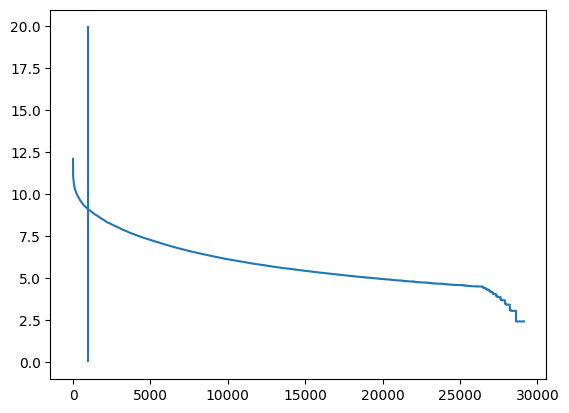

In [27]:
# log distribution of frequencies
import matplotlib.pyplot as plt
plt.close()
plt.plot(range(len(sorted_tfidf)), np.log(np.array(list(sorted_tfidf.values()))))
plt.vlines(limit, 0, 20)
plt.show()

## CL tokens

In [2]:
def filter_by_classes(dataset, classes_filter):
    return dataset.filter(lambda el: el['primary_cat'] in classes_filter)

In [5]:
def remap_classes(example):
    example['primary_cat'] = filtered_classes.index(example['primary_cat'])
    return example

In [ ]:
trds = []
for i in range(0, len(filtered_classes), 2):
    exp = [filtered_classes[i], filtered_classes[i+1]]
    
    tr_d = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'train', 'tokenized', 'pretrain_task_filtered')),
                             exp)
    tr_d = create_small_dataset(tr_d, patterns_per_class=10000)
    ts_d = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'test', 'tokenized', 'pretrain_task_filtered')),
                             exp)
    ts_d = create_small_dataset(ts_d, patterns_per_class=1000)
    
    
    tr_d_finetune = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'train', 'tokenized', 'finetuning_task_filtered')),
                             exp)
    tr_d_finetune = tr_d_finetune.map(remap_classes)
    ts_d_finetune = filter_by_classes(Dataset.load_from_disk(os.path.join(save_path, 'test', 'tokenized', 'finetuning_task_filtered')),
                             exp)
    ts_d_finetune = ts_d_finetune.map(remap_classes)
    tr_d_finetune, ts_d_finetune = create_small_dataset(tr_d_finetune, patterns_per_class=10000,
                                                        patterns_per_class_per_test=1000)
    trds.append(tr_d)

Getting tokens for experience  0
['observations', 'distribution', 'temperature', 'luminosity', 'parameters', 'evolution', 'structure', 'galaxies', 'emission', 'neutrino', 'observed', 'magnetic', 'clusters', 'spectrum', 'velocity', 'galactic', 'redshift', 'obtained', 'symmetry', 'spectral', 'cluster', 'sources', 'optical', 'spectra', 'discuss', 'galaxy', 'masses', 'theory', 'higgs', 'gamma', 'quark', 'decay', 'gauge', 'solar', 'flux', 'qcd', 'gev', '$\\', '}$']
Getting tokens for experience  1
['supersymmetric', 'entanglement', 'measurement', 'interaction', 'temperature', 'hamiltonian', 'dimensions', 'particular', 'conditions', 'classical', 'solutions', 'potential', 'equations', 'functions', 'operators', 'entangled', 'structure', 'conformal', 'theories', 'symmetry', 'coupling', 'equation', 'dynamics', 'boundary', 'particle', 'obtained', 'approach', 'solution', 'magnetic', 'possible', 'quantum', 'systems', 'entropy', 'discuss', 'optical', 'algebra', 'theory', 'photon', 'scalar', 'matrix'

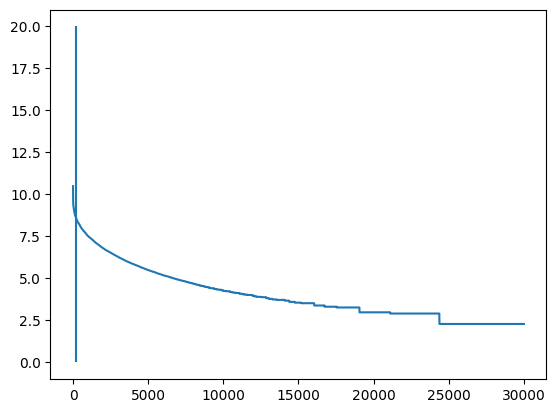

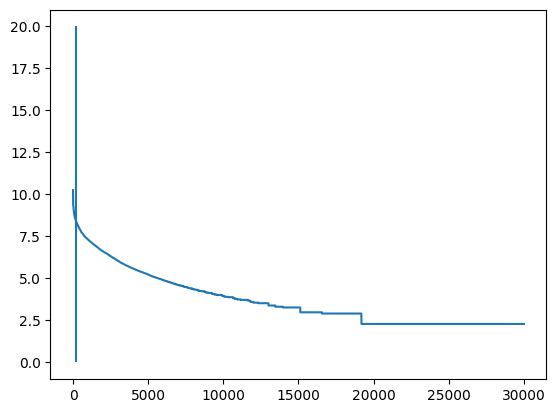

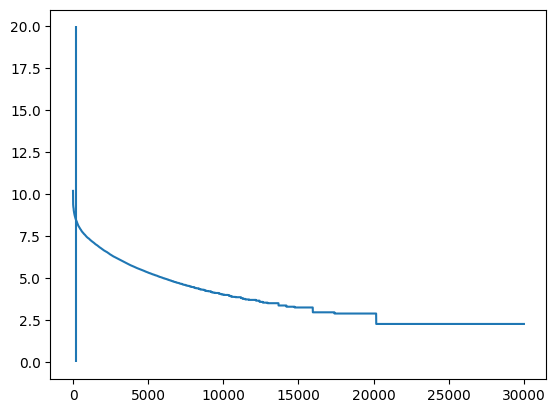

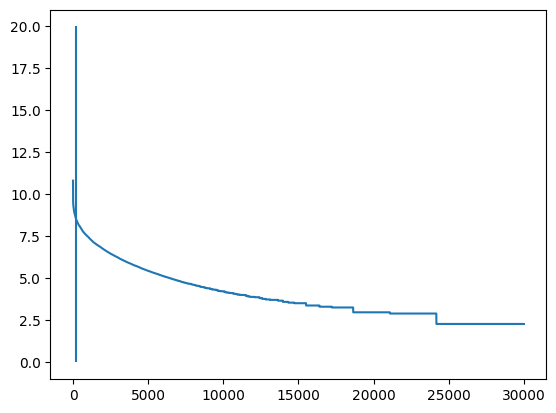

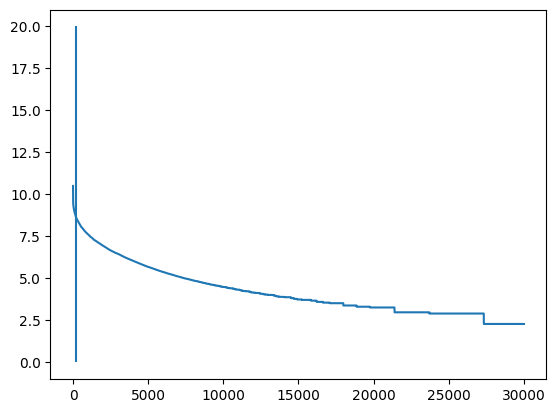

In [71]:
from datasets import concatenate_datasets
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers import Tokenizer

sorted_tfidf_list = []
toaddwords_sorted_list = []

for exp_id, tr_d in enumerate(trds):
    print("Getting tokens for experience ", exp_id)
    tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
    tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=["[UNK]"])

    def batch_iterator(batch_size=1000):
        for i in range(0, len(tr_d), batch_size):
            yield tr_d[i : i + batch_size]["abstract"]

    #tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(tr_d))
    #tokenizer.save(os.path.join(cache_dir, f'mywordleveltokenizer{exp_id}', 'mytokenizer.json'))

    tokenizer = Tokenizer.from_file(os.path.join(cache_dir, f'mywordleveltokenizer{exp_id}', 'mytokenizer.json'))

    from collections import defaultdict
    domain_seen_words = defaultdict(float)
    N_domain = tr_d.num_rows
    unks = set()
    unks_freq = 0
    for abstract in tr_d['abstract']:
        out = tokenizer.encode(abstract)
        for idx, i in enumerate(out.ids):
            if i == 0: # [UNK]
                unks_freq += 1
                start, end = out.offsets[idx]
                unks.add(abstract[start:end])
            domain_seen_words[i] += 1 


    sorted_domain_words = dict(sorted(domain_seen_words.items(), key=lambda x:x[1], reverse=True))


    from math import log

    ## IDF computation
    idf = defaultdict(float)
    for abstract in tr_d['abstract']:
        out = tokenizer.encode(abstract)
        setids = list(set(out.ids))
        for k in setids:
                idf[k] += 1

    idf = dict([(k, log(float(len(tr_d)) / v)) for k, v in idf.items()])


    tfidf = {}
    for k, tf in domain_seen_words.items():
        tfidf[k] = tf * idf[k]
    sorted_tfidf = dict(sorted(tfidf.items(), key=lambda x:x[1], reverse=True))
    sorted_tfidf_list.append(sorted_tfidf)

    limit = 200  # 100 per class
    if 0 in sorted_tfidf:
        del sorted_tfidf[0]
    words = list(sorted_tfidf.keys())[:limit]


    pretr = AutoTokenizer.from_pretrained("roberta-base", cache_dir=cache_dir)

    toadd, toaddwords = [], []
    for el in words:
        if tokenizer.decode([el]) not in pretr.vocab:
            toadd.append(el)
            toaddwords.append(tokenizer.decode([el]))

    toaddwords_sorted = list(sorted(toaddwords, key=lambda x: len(x), reverse=True))

    toaddwords_sorted_list.append(toaddwords_sorted)

import matplotlib.pyplot as plt
for sorted_tfidf in sorted_tfidf_list:
    plt.close()
    plt.plot(range(len(sorted_tfidf)), np.log(np.array(list(sorted_tfidf.values()))))
    plt.vlines(limit, 0, 20)
    plt.show()

In [74]:
additional_tokens_word_cl = [

['observations', 'distribution', 'temperature', 'luminosity', 'parameters', 'evolution', 'structure', 'galaxies', 'emission', 'neutrino', 'observed', 'magnetic', 'clusters', 'spectrum', 'velocity', 'galactic', 'redshift', 'obtained', 'symmetry', 'spectral', 'cluster', 'sources', 'optical', 'spectra', 'discuss', 'galaxy', 'masses', 'theory', 'higgs', 'gamma', 'quark', 'decay', 'gauge', 'solar', 'flux', 'qcd', 'gev', '$\\', '}$'],

['supersymmetric', 'entanglement', 'measurement', 'interaction', 'temperature', 'hamiltonian', 'dimensions', 'particular', 'conditions', 'classical', 'solutions', 'potential', 'equations', 'functions', 'operators', 'entangled', 'structure', 'conformal', 'theories', 'symmetry', 'coupling', 'equation', 'dynamics', 'boundary', 'particle', 'obtained', 'approach', 'solution', 'magnetic', 'possible', 'quantum', 'systems', 'entropy', 'discuss', 'optical', 'algebra', 'theory', 'photon', 'scalar', 'matrix', 'finite', 'branes', 'scheme', 'qubits', 'cavity', 'gauge', 'qubit', 'brane', 'dual', '$\\', '$-', ')$'],


['gravitational', 'cosmological', 'topological', 'temperature', 'interaction', 'conductance', 'relativity', 'transition', 'scattering', 'electronic', 'parameters', 'solutions', 'equations', 'transport', 'spacetime', 'potential', 'structure', 'parameter', 'tunneling', 'classical', 'numerical', 'electrons', 'magnetic', 'electron', 'graphene', 'coupling', 'equation', 'universe', 'einstein', 'solution', 'constant', 'dynamics', 'symmetry', 'approach', 'particle', 'obtained', 'momentum', 'observed', 'quantum', 'systems', 'horizon', 'optical', 'coupled', 'theory', 'scalar', 'metric', 'tensor', 'regime', 'modes', 'noise', 'dirac', 'gauge', '$\\', '}$'],


['antiferromagnetic', 'ferromagnetic', 'magnetization', 'calculations', 'interactions', 'experimental', 'measurements', 'temperatures', 'conductivity', 'temperature', 'topological', 'interaction', 'correlation', 'transition', 'electronic', 'scattering', 'dependence', 'structures', 'structure', 'materials', 'transport', 'insulator', 'potential', 'electrons', 'magnetic', 'electron', 'coupling', 'graphene', 'symmetry', 'observed', 'exchange', 'approach', 'obtained', 'dynamics', 'quantum', 'lattice', 'systems', 'orbital', 'optical', 'crystal', 'thermal', 'studied', 'theory', 'phases', 'phonon', 'doping', 'strain', 'finite', 'fermi', 'films', 'kondo', 'bulk', '}$', '$\\', '_2', '_3'],


['observations', 'distribution', 'temperature', 'simulations', 'equilibrium', 'transition', 'parameters', 'evolution', 'particles', 'structure', 'accretion', 'diffusion', 'magnetic', 'emission', 'observed', 'velocity', 'dynamics', 'obtained', 'rotation', 'spectral', 'particle', 'equation', 'systems', 'spectra', 'quantum', 'cluster', 'scaling', 'coronal', 'entropy', 'theory', 'solar', 'flare', 'dwarf', 'flux', '$\\', '}$']

]

In [87]:
# remove words present in previous experiences
additional_tokens_word_cl_noduplicates = [additional_tokens_word_cl[0]]
for tkslist in additional_tokens_word_cl[1:]:
    current_tokens = set(additional_tokens_word_cl_noduplicates[-1])
    new_tokens = list(set(tkslist).difference(current_tokens))
    additional_tokens_word_cl_noduplicates.append(new_tokens)
additional_tokens_word_cl_noduplicates

[['observations',
  'distribution',
  'temperature',
  'luminosity',
  'parameters',
  'evolution',
  'structure',
  'galaxies',
  'emission',
  'neutrino',
  'observed',
  'magnetic',
  'clusters',
  'spectrum',
  'velocity',
  'galactic',
  'redshift',
  'obtained',
  'symmetry',
  'spectral',
  'cluster',
  'sources',
  'optical',
  'spectra',
  'discuss',
  'galaxy',
  'masses',
  'theory',
  'higgs',
  'gamma',
  'quark',
  'decay',
  'gauge',
  'solar',
  'flux',
  'qcd',
  'gev',
  '$\\',
  '}$'],
 ['scalar',
  'boundary',
  'operators',
  'dimensions',
  'equation',
  'possible',
  'qubit',
  'finite',
  'equations',
  '$-',
  'theories',
  'systems',
  'photon',
  'functions',
  'cavity',
  'hamiltonian',
  'conformal',
  'approach',
  'particular',
  'qubits',
  'dual',
  'entangled',
  'entropy',
  'supersymmetric',
  'matrix',
  'potential',
  'branes',
  'particle',
  'brane',
  'solution',
  'coupling',
  'scheme',
  ')$',
  'measurement',
  'quantum',
  'conditions',
  '

## Generic finetuning task tokenization

In [ ]:
tr_d = load_dataset("emotion", split='train', cache_dir=cache_dir)
tv_d = load_dataset("emotion", split='validation', cache_dir=cache_dir)
ts_d = load_dataset("emotion", split='test', cache_dir=cache_dir)
pretr = AutoTokenizer.from_pretrained("roberta-base", cache_dir=cache_dir)

In [7]:
def tokenize(examples):
    return pretr(examples["text"], padding="max_length", truncation=True)
# tr_d_tk = tr_d.map(tokenize, batched=True, batch_size=1000)
# tr_d_tk.save_to_disk(os.path.join('/disk3/anonym/emotion/', 'train_tokenized'))

# tv_d_tk = tv_d.map(tokenize, batched=True, batch_size=1000)
# tv_d_tk.save_to_disk(os.path.join('/disk3/anonym/emotion/', 'valid_tokenized'))

# ts_d_tk = ts_d.map(tokenize, batched=True, batch_size=1000)
# ts_d_tk.save_to_disk(os.path.join('/disk3/anonym/emotion/', 'test_tokenized'))

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Generic finetuning 2: GLUE - semantic similarity task - SemEval 2017

Roberta has token_type_ids to distinguish first sentence from second but it only allows token types with value 0. However, sentences can still be distinguished since there is a double </s> tag between the first and the second.

Instead, BERT supports token_type_ids with 2 values.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("glue", "qnli", split='train', cache_dir="/disk3/anonym")

In [16]:
dataset[0]

{'question': 'When did the third Digimon series begin?',
 'idx': 0,
 'sentence': 'Unlike the two seasons before it and most of the seasons that followed, Digimon Tamers takes a darker and more realistic approach to its story featuring Digimon who do not reincarnate after their deaths and more complex character development in the original Japanese.',
 'label': 1}